In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io

# Programming Exercise 7: Anomaly Detection and Recommender Systems

## 1. Anomaly Detection

In this section, we will implement an anomaly detection algorithm using a Gaussian model to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server for $m$ = 307 examples. 

We will first start on a 2D dataset that will allow us to visualize what the algorithm is doing. On that dataset, we will fit a Gaussian distribution and then find values that have very low probability and hence can
be considered anomalies. After that, we will apply the anomaly detection algorithm to a larger dataset with many dimensions. 

We first load the dataset and visualize it.

In [2]:
# Read .mat file
data = io.loadmat('ex8data1.mat')

# Load X, Xval and yval
X = data["X"]
Xval = data["Xval"]
yval = data["yval"]

Text(0, 0.5, 'Throughput (mb/s)')

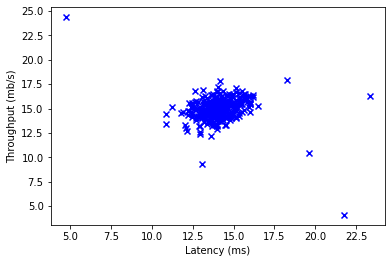

In [3]:
# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], marker = "x", color = "blue")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### 1.1 Gaussian Distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution. Given a training set ${x^{(1)}, \ldots, x^{(m)}}$ (where $x^{(i)}$ is an n-dimensional vector), you want to estimate the Gaussian distribution for each of the features $x_{i}$. For each feature $i = 1, \ldots, n$, you need to find parameters $\mu_{i}$ and $\sigma_{i}^{2}$ that fit the data in the $i$-th dimension ${x_{i}^{(1)}, \ldots, x_{i}^{(m)}}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by

$p(x; \mu, \sigma^{2}) = \frac{1}{\sqrt{2 \pi \sigma^{2}}} e^{-\frac{(x - \mu)^{2}}{2 \sigma^{2}}}$

where $\mu$ is the mean and $\sigma^{2}$ controls the variance.

### 1.2 Estimating Parameters for a Gaussian

You can estimate the parameters, ($\mu_{i}$, $\sigma_{i}^{2}$) of the $i$-th feature by using the following equations. 

To estimate the mean, you will use:

$\mu_{i} = \sum_{j = 1}^{m}x_{i}^{(j)}$

and for the variance you will use:

$\sigma_{i}^{2} = \frac{1}{m} \sum_{j = 1}^{m} (x_{i}^{(j)} - \mu_{i})^{2}$

We implement these calculations in the function `estimateGaussian` below.

In [4]:
#estimateGaussian estimates the parameters of a Gaussian distribution using the data in X
def estimateGaussian(X):
    # Initialize variables
    m = X.shape[0]
    
    # Compute for mean and variance
    mu = np.sum(X, axis = 0) / m
    sigma2 = np.sum((X - mu) ** 2, axis = 0) / m
    
    return mu, sigma2    

Having estimated our mean and variance, we can now proceed to constructing our multivariate Gaussian distribution. The following code does exactly that.

In [5]:
#multivariateGaussian computes the probability density function of the multivariate Gaussian distribution.
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    
    # Populate the diagonals of the covariance matrix with the variance
    sigma2 = np.diag(sigma2)
    
    # Normalize X
    X = X - mu.T
    
    # Compute probability
    p = 1 / ((2 * np.pi) ** (k / 2) * (np.linalg.det(sigma2) ** 0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(sigma2) * X, axis = 1))
    
    return p[:, np.newaxis]

We can now visualize the contours of the fitted Gaussian distribution. The code below uses specifications and implementations from the original Octave file.

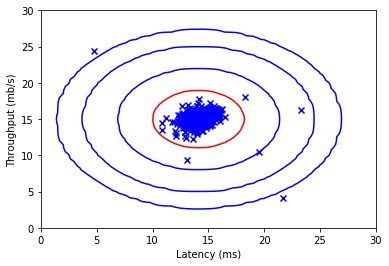

In [6]:
# Plot the data
plt.scatter(X[:, 0], X[:, 1], marker = "x", color = "blue")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

# Create meshgrid
X1, X2 = np.meshgrid(np.arange(0, 35, 0.5), np.arange(0,35, 0.5))

# Construct multivariateGaussian and plot contours
mu, sigma2 = estimateGaussian(X)
Z = multivariateGaussian(np.hstack((X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis])), mu, sigma2)
plt.contour(X1, X2, Z[:, np.newaxis].reshape(X1.shape), levels = np.logspace(-3, 20, 1), colors = "red")
plt.contour(X1, X2, Z[:, np.newaxis].reshape(X1.shape), levels = np.logspace(-20, 25, 8), colors = "blue")

From the plot, we can see that most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

### 1.3 Selecting the threshold $\epsilon$

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross-validation set. In the function `selectThreshold` that follows, we implement an algorithm to select the threshold $\epsilon$ using the $F_{1}$ score on a cross-validation set.

In [7]:
#selectThreshold finds the best threshold (epsilon) to use for selecting outliers
def selectThreshold(yval, pval):
    # Initialize variables
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (np.max(pval) - np.min(pval)) / 1000

    for epsilon in np.arange(np.min(pval), np.max(pval), stepsize):
        
        # Make prediction based on epsilon
        prediction = pval < epsilon
        
        # Calculate true positive, false positive and false negative
        tp = np.sum(prediction[yval == 1] == 1)
        fp = np.sum(prediction[yval == 0] == 1)
        fn = np.sum(prediction[yval == 1] == 0)
        
        # Calculate precision and recall
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        
        # Calculate F1 score
        F1 = (2 * prec * rec) / (prec + rec)
        
        # Set bestF1 and bestEpsilon
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    return bestEpsilon, bestF1

In [8]:
#TESTS
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print("Best epsilon found using cross-validation: ", epsilon)
print("Best F1 on Cross Validation Set: ", F1)
print("You should see a value epsilon of about 8.99e-05")
print("You should see a Best F1 value of 0.875000")

Best epsilon found using cross-validation:  8.990852779269496e-05
Best F1 on Cross Validation Set:  0.8750000000000001
You should see a value epsilon of about 8.99e-05
You should see a Best F1 value of 0.875000


c:\users\jm\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


After selecting the best threshold via cross-validation, the next step will be to run our anomaly detection code on the toy dataset. We do this and circle the anomalies in the plot below. 

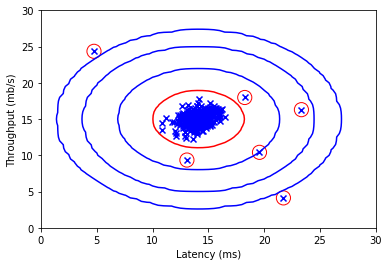

In [9]:
# Plot the data
plt.scatter(X[:, 0], X[:, 1], marker = "x", color = "blue")
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

# Construct multivariateGaussian and plot contours
mu, sigma2 = estimateGaussian(X)
Z = multivariateGaussian(np.hstack((X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis])), mu, sigma2)
plt.contour(X1, X2, Z[:, np.newaxis].reshape(X1.shape), levels = np.logspace(-3, 20, 1), colors = "red")
plt.contour(X1, X2, Z[:, np.newaxis].reshape(X1.shape), levels = np.logspace(-20, 25, 8), colors = "blue")

# Identify and encircle outliers
p = multivariateGaussian(X, mu, sigma2)
plt.scatter(X[(p < epsilon).flatten(), 0], X[(p < epsilon).flatten(), 1], marker = "o", s = 200, color = "none", linewidths = 1, edgecolor = "red")

### 1.3 High-dimensional dataset

We can now run this anomaly detection algorithm on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of the computer servers.

We first load the dataset.

In [10]:
# Read .mat file
data = io.loadmat('ex8data2.mat')

# Load X, Xval and yval
X = data["X"]
Xval = data["Xval"]
yval = data["yval"]

We now implement `estimateGaussian`, `multivariateGaussian` and `selectThreshold` to implement anomaly detection.

In [11]:
# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

# Training set 
p = multivariateGaussian(X, mu, sigma2)

# Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

# Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print("Best epsilon found using cross-validation: ", epsilon)
print("Best F1 on Cross Validation Set: ", F1)
print("You should see a value epsilon of about 1.38e-18")
print("You should see a Best F1 value of 0.615385")
print("# Outliers found: ", np.sum(p < epsilon))

Best epsilon found using cross-validation:  1.377228890761358e-18
Best F1 on Cross Validation Set:  0.6153846153846154
You should see a value epsilon of about 1.38e-18
You should see a Best F1 value of 0.615385
# Outliers found:  117


c:\users\jm\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


We see that $\epsilon$ is around 1.38e-18, and found 117 anomalies.

## 2. Recommender Systems

In this section, we will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_{u}$ = 943 users, and
$n_{m}$ = 1682 movies.

### 2.1 Movie ratings dataset

We first load the dataset onto our notebook.

In [12]:
# Read .mat file
data = io.loadmat('ex8_movies.mat')

# Load Y and R
Y = data["Y"]
R = data["R"]

The matrix $Y$ (a $n_{m} \times n_{u}$ matrix) stores the ratings $y(i,j)$ (from 1 to 5). The matrix $R$ is an binary-valued indicator matrix, where $R(i, j)$ = 1 if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. To help in understanding the matrix $Y$, the code that follows will compute the average movie rating for the first movie (Toy Story) and output the average rating to the screen. We will also visualize the matrix $Y$ by plotting it with `imshow`.

Average rating for movie 1 (Toy Story):  3.8783185840707963


Text(0.5, 0, 'Users')

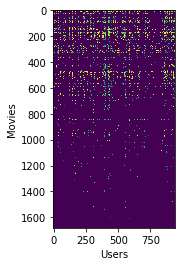

In [13]:
# Calculate the average movie rating for Toy Story
print("Average rating for movie 1 (Toy Story): ", np.sum(Y[0, :] * R[0, :]) / np.sum(R[0, :]))

#"Visualize" the ratings matrix
plt.imshow(Y)
plt.ylabel("Movies")
plt.xlabel("Users")

As you can see, the plot is filled with a lot of black spaces, corresponding to gaps in the $Y$ matrix, where a user has not rated a particular movie. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

Throughout this part of the exercise, you will also be working with the matrices, $X$ and $\Theta$:

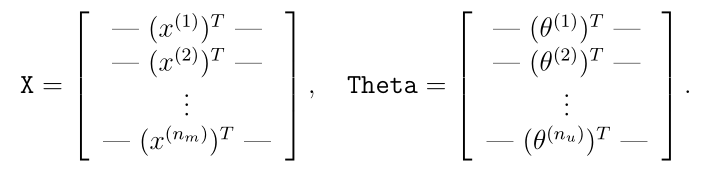

The $i$-th row of $X$ corresponds to the feature vector $x^{(i)}$ for the $i$-th movie, and the $j$-th row of $\Theta$ corresponds to one parameter vector $\theta^{(j)}$, for the $j$-th user. Both $x^{(i)}$ and $\theta^{(j)}$ are $n$-dimensional vectors. For the purposes of this section, we will use $n$ = 100. Correspondingly, $X$ is a $n_{m} \times$ 100 matrix and $\Theta$ is a $n_{u} \times$ 100 matrix.

### 2.2 Collaborative filtering learning algorithm

The collaborative filtering algorithm in the setting of movie recommendations considers a set of $n$-dimensional parameter vectors $x^{(1)}, \ldots, x^{(n_{m})}$ and $\theta^{(1)}, \ldots, \theta^{(n_{u})}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^{T}x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors
$x^{(1)}, \ldots, x^{(n_{m})}, \theta^{(1)}, \ldots, \theta^{(n_{u})}$ that produce the best fit (minimizes the squared error).

#### 2.2.1 Collaborative filtering cost function

We will start by implementing the cost function (without regularization). The collaborative filtering cost function (without regularization) is given by

$J(x^{(1)}, \ldots, x^{(n_{m})}, \theta^{(1)}, \ldots, \theta^{(n_{u})}) = \frac{1}{2}\sum_{(i,j): R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})^{2}$

We implement this in the following function `cofiCostFunc`.

In [14]:
#cofiCostFunc returns the cost for the collaborative filtering problem.
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmbda):
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Calculate cost without regularization
    prediction = X @ Theta.T
    error = prediction - Y
    J = (1 / 2) * np.sum(R * (error) ** 2)
    
    return J

In [15]:
#TESTS
# Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
params = io.loadmat('ex8_movieParams.mat')
X = params["X"]
Theta = params["Theta"]
num_users = params["num_users"]
num_movies = params["num_movies"]
num_features = params["num_features"]

# Reduce the data set size so that this runs faster
num_users_test = 4
num_movies_test = 5
num_features_test = 3
X_test = X[:num_movies_test, :num_features_test]
Theta_test = Theta[:num_users_test, :num_features_test]
Y_test = Y[:num_movies_test, :num_users_test]
R_test = R[:num_movies_test, :num_users_test]
params_test = np.append(X_test.flatten(), Theta_test.flatten())

# Compute for cost
J = cofiCostFunc(params_test, Y_test, R_test, num_users_test, num_movies_test, num_features_test, 0)
           
print("Cost at loaded parameters: ", J)
print("This value should be about 22.22.")

Cost at loaded parameters:  22.224603725685675
This value should be about 22.22.


#### 2.2.2 Collaborative filtering gradient

Now, we will implement the gradient (without regularization). The gradients of the cost function are given by:
    
$\frac{\partial J}{\partial x_{k}^{i}} = \sum_{j: R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})\theta_{k}^{(j)}$

$\frac{\partial J}{\partial \theta_{j}^{i}} = \sum_{i: R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})x_{k}^{(i)}$

We build this computation into our `cofiCostFunc` function from earlier.

In [16]:
#cofiCostFunc returns the cost and gradient for the collaborative filtering problem.
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmbda):
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Calculate cost without regularization
    prediction = X @ Theta.T
    error = prediction - Y
    J = (1 / 2) * np.sum(R * (error) ** 2)
    
    # Calculate gradient without regularization
    X_grad = R * error @ Theta
    Theta_grad = (R * error).T @ X
    grad = np.append(X_grad.flatten(), Theta_grad.flatten())
    
    return J, grad

#### 2.2.3 Regularized cost function 

The cost function for collaborative filtering with regularization is given by

$J(x^{(1)}, \ldots, x^{(n_{m})}, \theta^{(1)}, \ldots, \theta^{(n_{u})}) = \frac{1}{2}\sum_{(i,j): R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})^{2} + \frac{\lambda}{2} \sum_{j = 1}^{n_{u}} \sum_{k = 1}^{n} (\theta_{k}^{(j)})^{2} + \frac{\lambda}{2} \sum_{i = 1}^{n_{m}} \sum_{k = 1}^{n} (x_{k}^{(i)})^{2}$

We build this computation into our `cofiCostFunc` function from earlier.

In [17]:
#cofiCostFunc returns the cost and gradient for the collaborative filtering problem.
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmbda):
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Calculate cost with regularization
    prediction = X @ Theta.T
    error = prediction - Y
    J = (1 / 2) * np.sum(R * (error) ** 2) + (lmbda / 2) * (np.sum(Theta ** 2) + np.sum(X ** 2))

    # Calculate gradient without regularization
    X_grad = R * error @ Theta
    Theta_grad = (R * error).T @ X
    grad = np.append(X_grad.flatten(), Theta_grad.flatten())
            
    return J, grad

In [18]:
#TESTS
# Compute for cost
J, grad = cofiCostFunc(params_test, Y_test, R_test, num_users_test, num_movies_test, num_features_test, 1.5)

print("Cost at loaded parameters: ", J)
print("This value should be about 31.34.")

Cost at loaded parameters:  31.34405624427422
This value should be about 31.34.


#### 2.2.4 Regularized gradient 

Now that we have implemented the regularized cost function, we should proceed to implement regularization for the gradient. Note that the gradients for the regularized cost function is given by:

$\frac{\partial J}{\partial x_{k}^{i}} = \sum_{j: R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})\theta_{k}^{(j)} + \lambda x_{k}^{(i)}$

$\frac{\partial J}{\partial \theta_{j}^{i}} = \sum_{i: R(i,j) = 1} ((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})x_{k}^{(i)} + \lambda \theta_{k}^{(j)}$

We build this computation into our `cofiCostFunc` function from earlier.

In [19]:
#cofiCostFunc returns the cost and gradient for the collaborative filtering problem.
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmbda):
    # Unfold the X and Theta matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    # Calculate cost with regularization
    prediction = X @ Theta.T
    error = prediction - Y
    J = (1 / 2) * np.sum(R * (error) ** 2) + (lmbda / 2) * (np.sum(Theta ** 2) + np.sum(X ** 2))

    # Calculate gradient with regularization
    X_grad = R * error @ Theta + lmbda * X
    Theta_grad = (R * error).T @ X + lmbda * Theta
    grad = np.append(X_grad.flatten(), Theta_grad.flatten())
            
    return J, grad

### 2.3 Learning movie recommendations

We can now start training your algorithm to make movie recommendations. Before we train the collaborative filtering model, however, we will first add ratings that correspond to a new user that we just observed.

In [20]:
# Open movie_ids file
movieList = open("movie_ids.txt", "r").read().split("\n")

# Remove numbers
movieList = list(map(lambda x: x.lstrip('0123456789 '), movieList))

# Initialize my_ratings
my_ratings = np.zeros((1682, 1))

# Check the file movie_ids.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated ", my_ratings[i][0], " for ", movieList[i])

New user ratings:

Rated  4.0  for  Toy Story (1995)
Rated  3.0  for  Twelve Monkeys (1995)
Rated  5.0  for  Usual Suspects, The (1995)
Rated  4.0  for  Outbreak (1995)
Rated  5.0  for  Shawshank Redemption, The (1994)
Rated  3.0  for  While You Were Sleeping (1995)
Rated  5.0  for  Forrest Gump (1994)
Rated  2.0  for  Silence of the Lambs, The (1991)
Rated  4.0  for  Alien (1979)
Rated  5.0  for  Die Hard 2 (1990)
Rated  5.0  for  Sphere (1998)


Now, we will train the collaborative filtering model on a movie rating dataset of 1682 movies and 943 users. We first load the dataset once more and add our ratings onto the matrices.

In [21]:
# Read .mat file
data = io.loadmat('ex8_movies.mat')

# Load Y and R
Y = data["Y"]
R = data["R"]

# Add our own ratings to the data matrix
Y = np.hstack((my_ratings, Y))
R = np.hstack((my_ratings != 0, R))

We then need to implement the helper functions `normalizeRatings`, which demeans our ratings data and `gradientDescent` which will help us implement cost minimization.

In [22]:
#normalizeRatings preprocesses the data by subtracting mean rating for every movie (every row)
def normalizeRatings(Y, R):
    
    # Initialize variables
    num_movies, num_users = Y.shape
    Y_mean = np.zeros((num_movies, 1))
    Y_norm = np.zeros((num_movies, num_users))
    
    for i in range(num_movies):
        Y_mean[i] = np.sum(Y[i, :]) / np.sum(R[i, :])
        Y_norm[i, R[i, :] == 1] = Y[i, R[i, :] == 1] - Y_mean[i]
    
    return Y_norm, Y_mean

In [23]:
# gradientDescent performs gradient descent to learn theta.
def gradientDescent(params, Y, R, num_users, num_movies, num_features, num_iters, alpha, lmbda):
    # Initialize values
    J_history = np.zeros((num_iters, 1))
    
    # Unfold X and Theta parameters from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    # Perform gradient descent
    for i in range(num_iters):
        # Compute for cost and grad
        J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lmbda)
        
        # Unfold X_grad and Theta_grad from grad
        X_grad = grad[:num_movies * num_features].reshape(num_movies, num_features)
        Theta_grad = grad[num_movies * num_features:].reshape(num_users, num_features)
        
        # Update X and Theta
        X -= alpha * X_grad
        Theta -= alpha * Theta_grad
        
        # Repack X and Theta to params
        params = np.append(X.flatten(), Theta.flatten())
        
        # Save the cost of J in every iteration
        J_history[i, :] = J

    # Unfold final X and Theta parameters from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    return X, Theta, J_history

We now proceed to normalize the ratings and train our collaborative filtering algorithm using gradient descent.

In [24]:
# Normalize ratings
Y_norm, Y_mean = normalizeRatings(Y, R)

# Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(), Theta.flatten())

# Set regularization parameter, learning rate and number of iteraitions
lmbda = 10
alpha = 0.001
num_iters = 400

# Perform gradient descent
X_learned, Theta_learned, J_history = gradientDescent(initial_parameters, Y, R, num_users, num_movies, num_features, num_iters, alpha, lmbda)

After training the model, you can now make recommendations by computing the predictions matrix.

In [25]:
# Make predictions
p = X @ Theta_learned.T
my_predictions = p[:, 0][:, np.newaxis] + Y_mean

r = np.sort(my_predictions.flatten())[::-1]
ix = np.argsort(my_predictions.flatten())[::-1]

# Display recommendations
print("Top recommendations for you:\n")
for i in range(10):
    j = ix[i]
    print("Predicting rating", my_predictions[j][0], " for movie ", movieList[j])

print("\nOriginal ratings provided:\n")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated ", my_ratings[i][0], " for ", movieList[i])

Top recommendations for you:

Predicting rating 9.89209248668385  for movie  Jaws (1975)
Predicting rating 8.68759675221061  for movie  Ninotchka (1939)
Predicting rating 8.438186682865524  for movie  Charade (1963)
Predicting rating 8.275843030635823  for movie  Nell (1994)
Predicting rating 7.967876067228165  for movie  Love and a .45 (1994)
Predicting rating 7.5873076001276285  for movie  Forrest Gump (1994)
Predicting rating 7.552608403668636  for movie  Abyss, The (1989)
Predicting rating 7.540092159980896  for movie  Gate of Heavenly Peace, The (1995)
Predicting rating 7.459095544220873  for movie  Someone Else's America (1995)
Predicting rating 7.415816891417132  for movie  Johnny Mnemonic (1995)

Original ratings provided:

Rated  4.0  for  Toy Story (1995)
Rated  3.0  for  Twelve Monkeys (1995)
Rated  5.0  for  Usual Suspects, The (1995)
Rated  4.0  for  Outbreak (1995)
Rated  5.0  for  Shawshank Redemption, The (1994)
Rated  3.0  for  While You Were Sleeping (1995)
Rated  5.0